[0.0, -300.1445729954889, -301.2902523582084, -305.42425628566525, -310.570582761346, -319.1184611335959, -334.4361935345811, -353.07500515516995, -384.2758852082383, -411.5564762675193, -473.893316350597, -516.2516569337708, -588.1182580300745, -653.5980418888652, -756.0155270003303, -812.0475143089052, -934.2745745882181, -992.7837792475392, -1019.5551069106657, -1034.8512790933391, -1037.014571563902, -1030.1824035264162, -1009.2469871986898, -984.6158899664784, -957.5212777833998, -941.08096008637, -935.7659873335642, -946.6059059091115, -971.4283709187252, -1009.3576498036999, -1064.9706608417441, -1159.111006524326, -1284.7843358510922, -1483.2317137918672, -1838.448739895112, -2244.6292188748957, -2685.500563163549, -3214.6740186968327, -3827.689692105687, -4634.132295253637, -5160.484250900946, -5484.074437059966, -5455.626947840239, -5359.614889632313, -4920.162274928224, -4346.3636389732055, -3852.8488978294454, -3460.0349844685784, -3280.76479217723, -3165.203798962069, -323

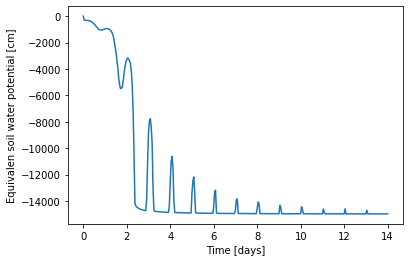

In [10]:
''' Soybean model '''

import matplotlib.pyplot as plt
from vtk_tools_new import *
import van_genuchten as vg
import math
import numpy as np
from scipy.linalg import block_diag
import glob

# go to the right place
name = 'singleroot_HLCT'
Hseq_t = []

filelist = glob.iglob(r'../../../build-cmake/rosi_benchmarking/coupled_1p_richards/results_' + name + '/*.vtp')
for filepath in sorted(filelist):
    kr, z = read3D_vtp_kr(filepath)					# get radial conductivity from root vtp
    kx, z = read3D_vtp_kx(filepath)					# get axial conductivity from root vtp
    nodes = read3D_vtp_nodes(filepath)				# get RA connectivity from root vtp
    p, z = read3D_vtp_soilp(filepath)				# get soil voxel pressure from root vtp

    diag_kx = np.diag(kx)						# create a diagonal matrix of kx
    diag_kr = np.diag(kr)						# create a diagonal matrix of kr
    diag_k = block_diag(diag_kx, diag_kr)				# create a big diagonal matrix of kx and kr
    
    IM = np.zeros(shape=(np.shape(diag_k)))				# create IM matrix with all zeros
    np.fill_diagonal(IM, 1)						# fill all diagonal elements with "1"
    for i in range(len(diag_kx)):
        IM[i][i+1] = -1						# fill all "-1" using connectivity values
    
    n,m = IM.shape 							# for generality
    T = np.ones((n,1))							# first column with collar connectivity (fill all 1 since it doesn't matter)
    IM_T = np.hstack((T,IM))						# add it to IM to create IMt
    C = np.matmul(IM, diag_k)						# multiply IM with diag(K)
    C = np.matmul(C, IM_T)						# multiply with IMt --> connectivity matrix

    C2 = C[0:len(diag_kx), 1:len(diag_kx)+1]				# create C2 matrix
    C3 = C[0:len(diag_kx), len(diag_kx) + 1:2*len(diag_kx)+1]	# create C3 matrix
    inv_C2 = np.linalg.inv(C2)					# get inverse of C2
    C2_C3 = np.matmul(inv_C2, C3)					# get [C2^-1 * C3]
    I = np.identity(len(C3))						# create identity matrix of size of C3
    I = I + C2_C3							# I + [C2^-1C3]
    C4 = np.matmul(diag_kr, I)					# get C4 matrix

    SUF = [] 								# define an empty array to store SUF
    total = np.sum(C4)							# sum of all elements of C4
    for i in range(len(C4)):						# sum of all elements in a row 'i' of C4
        x = sum(C4[i])
        x = x/total							# compute SUF of each element
        SUF.append(x)							# store SUF in a array

    for j in range(len(SUF)):
        Hseq = np.multiply(SUF, p)					# compute equivalent soil water potential of each segment
    
    Hseq_ = np.sum(Hseq)						    # total equivalent soil water potential
    Hseq_t.append(Hseq_)

print(Hseq_t)
#    Figure
fig, ax1 = plt.subplots()
time = np.linspace(0,14,337)
ax1.plot(time, Hseq_t, '-')   
ax1.set_xlabel("Time [days]")
ax1.set_ylabel("Equivalen soil water potential [cm]")
fig.savefig("equivalent_soilp.pdf")
plt.show()

In [ ]:
diag_kx = np.diag(kx)
diag_kr = np.diag(kr)
diag_k = block_diag(diag_kx, diag_kr)
IM = np.zeros(shape=(np.shape(diag_k)))
np.fill_diagonal(IM, 1)
print(IM)

In [ ]:
for i in range(len(diag_kx)):
    IM[i][i+1] = -1

print(IM)

In [ ]:
n,m = IM.shape # for generality
T = np.ones((n,1))
IM_T = np.hstack((T,IM))
C = np.matmul(IM, diag_k)
C = np.matmul(C, IM_T)

C2 = C[0:len(diag_kx), 1:len(diag_kx)+1]
C3 = C[0:len(diag_kx), len(diag_kx) + 1:2*len(diag_kx)+1]
inv_C2 = np.linalg.inv(C2)
C2_C3 = np.matmul(inv_C2, C3)
I = np.identity(len(C3))
I = I + C2_C3
C4 = np.matmul(diag_kr, I)
print(C4)
# SUF
SUF = [] # define an empty array
total = np.sum(C4)
for i in range(len(C4)):
    x = sum(C4[i])
    x = x/total
    SUF.append(x)

print(SUF)

for j in range(len(SUF)):
    Hseq = np.multiply(SUF, p)

print(np.sum(Hseq))

In [ ]:
# Figure
plt.plot(p, z * 100, "r+")
plt.xlabel('$\psi$ (cm)')
plt.ylabel('Depth (cm)')
plt.show()